Import Library

In [ ]:
import os 
import random 
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

#import tensorflow as tf
from tensorflow.random import set_seed
#tf.set_random_seed(33)
set_seed(33)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('weatherHistory.csv')

In [ ]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


Function

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y, X_test, y_test = list(), list(), list(), list() 
    for i in range(len(sequence)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the sequence
      if out_end_ix > len(sequence):
        break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]

      if i <= 1944:
        X.append(seq_x)
        y.append(seq_y)
      else:
        X_test.append(seq_x)
        y_test.append(seq_y)

    return np.array(X), np.array(y), np.array(X_test),np.array(y_test)
    print(x.dtype())

Pre-processing

In [ ]:
df_fundamentals = pd.read_csv("weatherHistory.csv")
df_fundamentals = df_fundamentals.set_index("Formatted Date")
df_fundamentals.index = pd.to_datetime(df_fundamentals.index)

In [ ]:
df_fundamentals.columns

Index(['Summary', 'Precip Type', 'Temperature (C)', 'Apparent Temperature (C)',
       'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
       'Visibility (km)', 'Loud Cover', 'Pressure (millibars)',
       'Daily Summary'],
      dtype='object')

In [ ]:
df_fundamentals = df_fundamentals[['Temperature (C)', 'Humidity', 'Pressure (millibars)', 'Wind Speed (km/h)']]

In [ ]:
df_fundamentals.index = pd.to_datetime(df_fundamentals.index, utc=True)
df_fundamentals = df_fundamentals.resample('1D').mean()

In [ ]:
df_fundamentals.head()

,Temperature (C),Humidity,Pressure (millibars),Wind Speed (km/h)
Formatted Date,,,,
2005-12-31 00:00:00+00:00,0.577778,0.890000,1016.660000,17.114300
2006-01-01 00:00:00+00:00,4.075000,0.817083,1011.985000,21.229192
2006-01-02 00:00:00+00:00,5.263194,0.847083,1010.384167,17.824713
2006-01-03 00:00:00+00:00,2.340509,0.897083,1021.170833,7.726658
2006-01-04 00:00:00+00:00,2.251852,0.906667,981.770833,12.152817


In [ ]:
df_fundamentals.columns

Index(['Temperature (C)', 'Humidity', 'Pressure (millibars)',
       'Wind Speed (km/h)'],
      dtype='object')

In [ ]:
# normalize data into 0 to 1 using MinMaxScaler
scaler = MinMaxScaler()
df_transformed = scaler.fit_transform(df_fundamentals)

In [ ]:
array_sum = np.sum(df_transformed)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False


Split Sequence

(x, x+1, x+2, .... x+119) > (x+120)

(x+1, x+2, x+3, .... x+119) > (x+121)

In [ ]:

# choose a number of time steps
n_steps_in, n_steps_out = 130, 1

# split into samples
X, y, X_test, y_test = split_sequence(df_transformed, n_steps_in, n_steps_out)
n_features, n_epochs, n_neurons = df_fundamentals.columns.size, 10, 50

In [ ]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(1945, 130, 4)
(1945, 1, 4)
(1944, 130, 4)
(1944, 1, 4)


Training

In [ ]:
# define model
model = Sequential()
model.add(LSTM(n_neurons, activation='tanh', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out)) 
model.add(LSTM(n_neurons, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X[:-1], y[:-1], epochs=n_epochs,verbose=1)

Epoch 1/10
61/61 [==============================] - 10s 31ms/step - loss: 0.1092 - accuracy: 0.7423
Epoch 2/10
61/61 [==============================] - 2s 31ms/step - loss: 0.0213 - accuracy: 0.9475
Epoch 3/10
61/61 [==============================] - 2s 31ms/step - loss: 0.0141 - accuracy: 0.9475
Epoch 4/10
61/61 [==============================] - 2s 31ms/step - loss: 0.0128 - accuracy: 0.9470
Epoch 5/10
61/61 [==============================] - 2s 31ms/step - loss: 0.0122 - accuracy: 0.9475
Epoch 6/10
61/61 [==============================] - 2s 31ms/step - loss: 0.0119 - accuracy: 0.9475
Epoch 7/10
61/61 [==============================] - 2s 32ms/step - loss: 0.0114 - accuracy: 0.9475
Epoch 8/10
61/61 [==============================] - 2s 31ms/step - loss: 0.0112 - accuracy: 0.9470
Epoch 9/10
61/61 [==============================] - 2s 32ms/step - loss: 0.0109 - accuracy: 0.9486
Epoch 10/10
61/61 [==============================] - 2s 32ms/step - loss: 0.0108 - accuracy: 0.9480


In [ ]:
import tensorflow as tf
model.save("tanh_latest.hS")
model = tf.keras.models.load_model("tanh_latest.hS")

INFO:tensorflow:Assets written to: tanh_latest.hS/assets


INFO:tensorflow:Assets written to: tanh_latest.hS/assets


In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
16/16 [==============================] - 1s 15ms/step - loss: 0.0116 - accuracy: 0.9558
test loss, test acc: [0.011624417267739773, 0.9557613134384155]


Test

In [ ]:
Y_real = scaler.inverse_transform(y_test[:,0])
len(Y_real[:,0])

1944

In [ ]:
df_fundamentals.tail(47)

,Temperature (C),Humidity,Pressure (millibars),Wind Speed (km/h)
Formatted Date,,,,
2016-11-15 00:00:00+00:00,5.288889,0.848750,1019.073750,10.363704
2016-11-16 00:00:00+00:00,5.119444,0.850417,1019.062917,10.459633
2016-11-17 00:00:00+00:00,4.952546,0.852083,1019.057500,10.575688
2016-11-18 00:00:00+00:00,4.788657,0.854583,1019.055833,10.662225
2016-11-19 00:00:00+00:00,4.625231,0.857500,1019.060833,10.738700
2016-11-20 00:00:00+00:00,4.464352,0.858333,1019.071667,10.805783
2016-11-21 00:00:00+00:00,4.305556,0.860417,1019.084583,10.847375
2016-11-22 00:00:00+00:00,4.148843,0.862917,1019.104583,10.869512
2016-11-23 00:00:00+00:00,3.994444,0.864583,1019.126667,10.904396


In [ ]:
Y_predict = []
for i in range(len(X_test)):
  x_pred = X_test[i].reshape((1, X_test[i].shape[0], n_features))
  y_pred = model.predict(x_pred)
  y_pred_itrans = scaler.inverse_transform(y_pred[0])
  Y_predict.append(y_pred_itrans)

Y_predict

[array([[2.2423338e+01, 5.9556860e-01, 1.0003299e+03, 8.9171915e+00]],
       dtype=float32),
 array([[2.1210915e+01, 6.3214678e-01, 1.0006994e+03, 8.8552608e+00]],
       dtype=float32),
 array([[2.0562166e+01, 6.5018809e-01, 9.9986798e+02, 8.5375872e+00]],
       dtype=float32),
 array([[1.9796926e+01, 6.6545248e-01, 9.9941309e+02, 8.4873629e+00]],
       dtype=float32),
 array([[1.9245525e+01, 6.7487246e-01, 1.0001797e+03, 8.6341896e+00]],
       dtype=float32),
 array([[1.9727570e+01, 6.5925264e-01, 9.9998187e+02, 8.6331882e+00]],
       dtype=float32),
 array([[2.054158e+01, 6.387402e-01, 9.998205e+02, 8.731257e+00]],
       dtype=float32),
 array([[2.0715570e+01, 6.3338077e-01, 9.9359125e+02, 8.8687420e+00]],
       dtype=float32),
 array([[2.095336e+01, 6.238590e-01, 9.943709e+02, 8.806608e+00]],
       dtype=float32),
 array([[2.1422539e+01, 6.1191839e-01, 9.9533716e+02, 8.8418741e+00]],
       dtype=float32),
 array([[2.1074158e+01, 6.1191958e-01, 9.9540198e+02, 8.9513912e+00]

In [ ]:
len(Y_predict)

NameError: ignored

In [ ]:
Temp, Humidity, Pressure, WindSpd = [], [], [], []
for elements in Y_predict:
  Temp.append(elements[0][0])
  Humidity.append(elements[0][1])
  Pressure.append(elements[0][2])
  WindSpd.append(elements[0][3])

In [ ]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from math import sqrt

# Metrics comparision
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Temp_mae = mean_absolute_error(Temp, Y_real[:,0])
Temp_rmse = sqrt(mean_squared_error(Temp, Y_real[:,0]))
Temp_mape = mean_absolute_percentage_error(Temp, Y_real[:,0])

Humidity_mae = mean_absolute_error(Humidity, Y_real[:,1])
Humidity_rmse = sqrt(mean_squared_error(Humidity, Y_real[:,1]))
Humidity_mape = mean_absolute_percentage_error(Humidity, Y_real[:,1])

Pressure_mae = mean_absolute_error(Pressure, Y_real[:,2])
Pressure_rmse = sqrt(mean_squared_error(Pressure, Y_real[:,2]))
Pressure_mape = mean_absolute_percentage_error(Pressure, Y_real[:,2])

WindSpd_mae = mean_absolute_error(WindSpd, Y_real[:,3])
WindSpd_rmse = sqrt(mean_squared_error(WindSpd, Y_real[:,3]))
WindSpd_mape = mean_absolute_percentage_error(WindSpd, Y_real[:,3])

In [ ]:
results = pd.DataFrame({
    'Variable' : ['Temp', 'Humidity', 'Pressure', 'WindSpd'],
    'MAE' : [Temp_mae, Humidity_mae, Pressure_mae, WindSpd_mae],
    'RMSE' : [Temp_rmse, Humidity_rmse, Pressure_rmse, WindSpd_rmse],
    'MAPE' : [Temp_mape, Humidity_mape, Pressure_mape, WindSpd_mape],
})

result_df = results.sort_values(by = 'MAE', ascending = False)
result_df = result_df.set_index('Variable')
result_df

,MAE,RMSE,MAPE
Variable,,,
Pressure,24.846104,67.266880,2.594966
WindSpd,3.576594,4.760024,34.998207
Temp,2.645308,3.288745,1037.543564
Humidity,0.069485,0.087639,9.621566


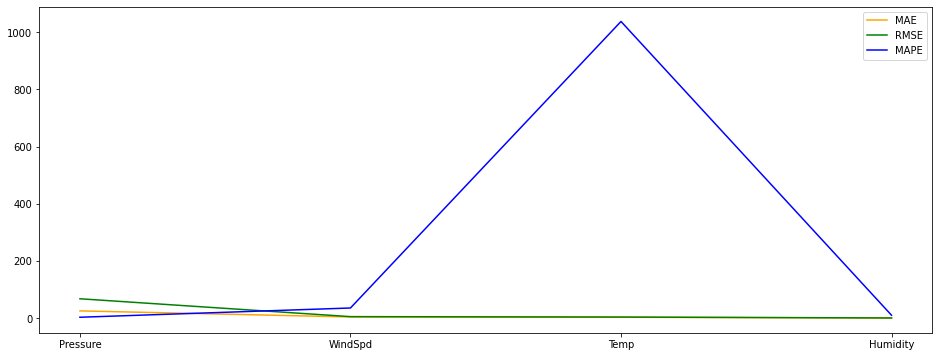

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(result_df.index, result_df.iloc[:,:1], c='orange', label='MAE')
plt.plot(result_df.index, result_df.iloc[:,1:2], c='green', label='RMSE')
plt.plot(result_df.index, result_df.iloc[:,2:3], c='blue', label='MAPE')
plt.legend();

In [ ]:
df_fundamentals.describe()

,Temperature (C),Humidity,Pressure (millibars),Wind Speed (km/h)
count,4019.000000,4019.000000,4019.000000,4019.000000
mean,11.927112,0.734940,1003.236631,10.813734
std,8.787951,0.134981,71.232784,5.001659
min,-15.958796,0.297500,336.542500,1.110900
25%,5.038310,0.632083,1010.817292,7.233260
50%,12.174074,0.744167,1015.989167,9.926321
75%,19.186690,0.842500,1020.556667,13.364677
max,30.814352,0.995000,1043.532083,37.929588


In [ ]:
date = df_fundamentals.tail(1944).index

Text(0, 0.5, 'Temp')

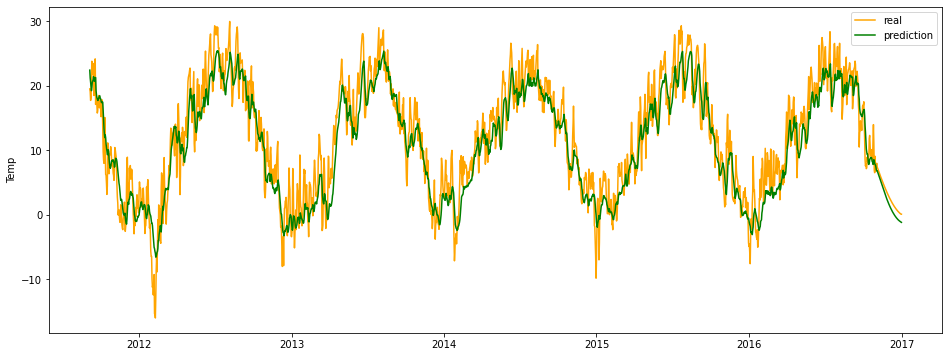

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(date, Y_real[:,0], c='orange', label='real')
plt.plot(date, Temp, c='green', label='prediction')
plt.legend(); plt.ylabel('Temp')

Text(0, 0.5, 'Humidity')

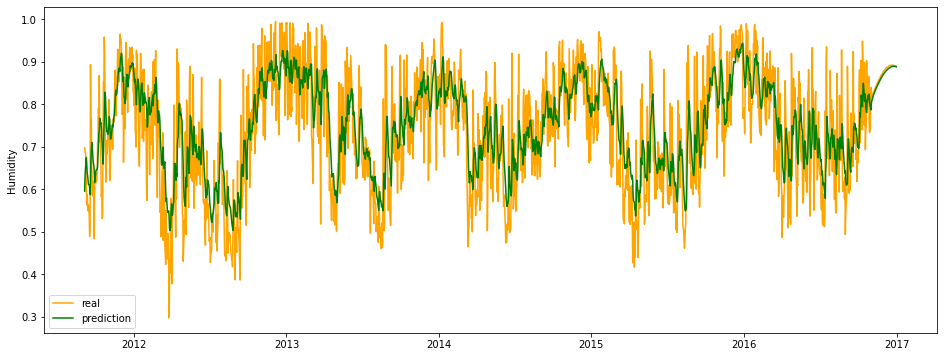

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(date, Y_real[:,1], c='orange', label='real')
plt.plot(date, Humidity, c='green', label='prediction')
plt.legend(); plt.ylabel('Humidity')

Text(0, 0.5, 'Pressure')

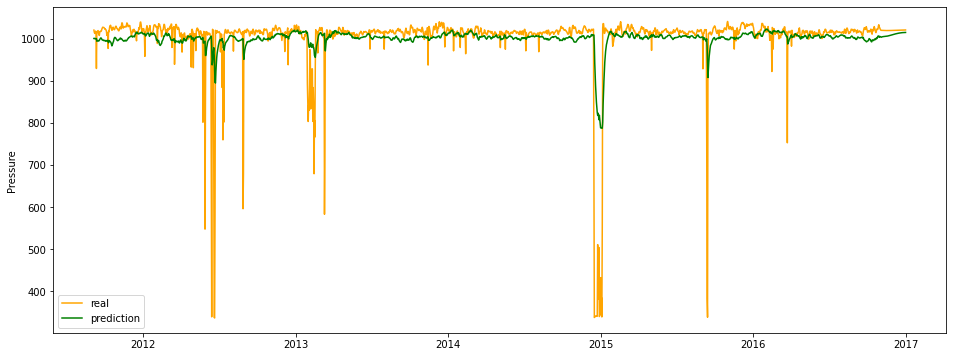

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(date, Y_real[:,2], c='orange', label='real')
plt.plot(date, Pressure, c='green', label='prediction')
plt.legend(); plt.ylabel('Pressure')

Text(0, 0.5, 'Wind Speed')

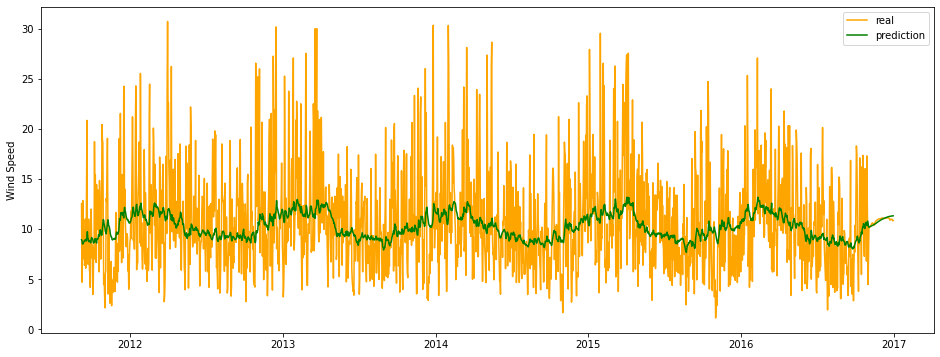

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(date, Y_real[:,3], c='orange', label='real')
plt.plot(date, WindSpd, c='green', label='prediction')
plt.legend(); plt.ylabel('Wind Speed')